In [25]:
import mat73
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import hamming_loss, accuracy_score
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

In [26]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()):
    if "anuja" in os.environ.get('USER'):
        DATA_DIR = 'data/'
    elif 'ubuntu' in os.environ.get('USER'):
        DATA_DIR = '/home/ubuntu/Martyna/repo/AI4Health/DATAfoof/'
    

In [27]:
path = os.path.join(DATA_DIR, 'split_data')
#loading
train_features = pd.read_pickle(os.path.join(path, 'train_features_source.pkl'))
test_features = pd.read_pickle(os.path.join(path, 'test_features_source_classification.pkl'))
train_labels = pd.read_pickle(os.path.join(path, 'train_labels_classification.pkl'))
test_labels = pd.read_pickle(os.path.join(path, 'test_labels_classification.pkl'))

train_features = np.array(train_features)
test_features = np.array(test_features)
train_labels = np.array(train_labels) 
test_labels = np.array(test_labels) 

In [28]:
age_gender = True
if age_gender:
    train_age_gender = train_features[:,-2:]
    test_age_gender = test_features[:,-2:]
    train_features = train_features[:,:-2]
    test_features = test_features[:,:-2]

## DATA NORMALISATION

In [29]:
#scaling features

# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_features)

# transform training data
train_features = norm.transform(train_features)
test_features = norm.transform(test_features)

print(train_features.shape, test_features.shape)

(1440, 2788) (481, 2788)


## PCA

In [30]:
# dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(.95) # 95% variance retained
pca.fit(train_features)

# transform data
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
print(train_features.shape, test_features.shape)

(1440, 421) (481, 421)


In [31]:
if age_gender:
    train_features = np.concatenate([train_features, train_age_gender], axis = 1)
    test_features = np.concatenate([test_features, test_age_gender], axis = 1)

## Metrics

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

n_classes = train_labels.shape[1]

def plot_pr_curve(Y_test, y_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict() #actually stores AUC
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        Y_test.ravel(), y_score.ravel()
    )
#     average_precision["micro"] = auc(recall["micro"], precision["micro"])
    average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
    average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")

#     average_precision["macro"] = np.average(list(average_precision.values()))

    _, ax = plt.subplots(figsize=(8, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i in range(n_classes):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}")

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best")
    ax.set_title("Precision-Recall curve")
    plt.show()
    
    return average_precision["macro"]
    
def plot_roc_curve(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operator characteristics')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc["macro"]

In [33]:
def brier_multi(targets, probs):
    return np.mean(np.mean((probs - targets)**2, axis=1))

def evaluate(y_test, y_pred_prob, brier=True):
    y_pred = y_pred_prob.round()
    accuracy = accuracy_score(y_test, y_pred)
    hamming = hamming_loss(y_test, y_pred)
    brier_score = brier_multi(y_test, y_pred_prob)
    report = skm.classification_report(y_test,y_pred, zero_division=1, output_dict=True)
    
    print("Accuracy:", accuracy)
    print("Hamming Loss:", hamming)
    if brier:
        print("Brier Score:", brier_score)
    print("Classification Report:\n", skm.classification_report(y_test,y_pred, zero_division=1))
    print("Confusion matrix:\n", skm.multilabel_confusion_matrix(y_test, y_pred))
    
    return accuracy,  hamming, brier_score, report

## MODELS

In [34]:
model_names, model_names_all = [], []
accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc = [], [], [], [], [], [], [], []
accuracy_scores_all, hamming_all, brier_score_all, precision_all, recall_all, f1_score_all, pr_auc_all, roc_auc_all = [], [], [], [], [], [], [], []
accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std = [], [], [], [], [], [], [], []

def record_values(a, h, b, p, r, f, pr, roc,a_std, h_std, b_std, p_std, r_std, f_std, pr_std, roc_std, model_name=''):
    accuracy_scores.append(a)
    hamming.append(h)
    brier_score.append(b)
    precision.append(p)
    recall.append(r)
    f1_score.append(f)
    pr_auc.append(pr)
    roc_auc.append(roc)
    
    accuracy_scores_std.append(a_std)
    hamming_std.append(h_std)
    brier_score_std.append(b_std)
    precision_std.append(p_std)
    recall_std.append(r_std)
    f1_score_std.append(f_std)
    pr_auc_std.append(pr_std)
    roc_auc_std.append(roc_std)
    model_names.append(model_name)

def record_values_all(a, h, b, p, r, f, pr, roc, model_name=''):
    accuracy_scores_all.append(a)
    hamming_all.append(h)
    brier_score_all.append(b)
    precision_all.append(p)
    recall_all.append(r)
    f1_score_all.append(f)
    pr_auc_all.append(pr)
    roc_auc_all.append(roc)
    model_names_all.append(model_name)

In [35]:
def ci(vals):
    return np.percentile(vals, 5), np.percentile(vals, 95)

In [36]:
# specify runs here
n = 100

## RANDOM BASELINE

### Shuffling

In [37]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_shuffled = np.copy(test_labels)
    np.random.shuffle(predicted_labels_shuffled)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_shuffled)
    pr = plot_pr_curve(test_labels, predicted_labels_shuffled)
    roc = plot_roc_curve(test_labels, predicted_labels_shuffled)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Shuffling Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Shuffling Baseline')

### Always Zero Baseline

In [38]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    predicted_labels_always_zero = np.zeros_like(test_labels)
    # add noise
    noise = np.random.rand(test_labels.shape[0], test_labels.shape[1])
    predicted_labels_always_zero = predicted_labels_always_zero + 1e-4*noise
    
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_always_zero)
    pr = plot_pr_curve(test_labels, predicted_labels_always_zero)
    roc = plot_roc_curve(test_labels, predicted_labels_always_zero)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Always Zero Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Always Zero Baseline')

### Label Proportion Baseline

In [39]:
%%capture

import sys, os

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    
    predicted_labels_proportion = [np.mean(train_labels == 1, axis=0)]*test_labels.shape[0]
    predicted_labels_proportion = np.array(predicted_labels_proportion)

    #add noise
    noise = np.random.randn(test_labels.shape[0], test_labels.shape[1])
    predicted_labels_proportion = predicted_labels_proportion + 1e-4*noise
    
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_proportion)
    pr = plot_pr_curve(test_labels, predicted_labels_proportion)
    roc = plot_roc_curve(test_labels, predicted_labels_proportion)
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'Label Proportion Baseline')
    

vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'Label Proportion Baseline')

## MULTI OUTPUT CLASSIFIER

In [ ]:
%%capture

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

forest = RandomForestClassifier() 
lg = LogisticRegression()
models = [lg, forest]
number_of_bootstraps = 10
seed_value = 7

for model in models:
    if str(model) == "RandomForestClassifier()":
        name = 'RandFor'  
    elif str(model) == "LogisticRegression()":
        name = 'LogReg'

    a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []
    for i in range(n):

        multi_output_model = MultiOutputClassifier(model, n_jobs=-1)
        multi_output_model.fit(train_features, train_labels)

        # Boostrap
        resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

        predicted_labels = np.asarray(multi_output_model.predict_proba(resampled_xtest))[:, :, 1].T
        print(str(model)+':')
        accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels)
        pr = plot_pr_curve(resampled_ytest, predicted_labels)
        roc = plot_roc_curve(resampled_ytest, predicted_labels)
        
        a_avg.append(accuracy_)
        h_avg.append(hamming_)
        b_avg.append(brier_score_)
        p_avg.append(report_['micro avg']['precision'])
        r_avg.append(report_['micro avg']['recall'])
        f_avg.append(report_['micro avg']['f1-score'])
        pr_avg.append(pr)
        roc_avg.append(roc)
        record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'MOC-'+str(name))
    
    
    vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
    means = [np.mean(v) for v in vals]
    cis = [ci(v) for v in vals]
    record_values(*means, *cis, 'MOC-'+str(name))

## Label Powerset

In [41]:
%%capture

from skmultilearn.problem_transform import LabelPowerset

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):
    classifier = LabelPowerset(LogisticRegression())
    classifier.fit(train_features, train_labels)

    # Boostrap
    resampled_xtest, resampled_ytest = resample(test_features, test_labels, replace=True, n_samples=len(test_features), random_state=seed_value+i)

    
    predicted_labels_lp = classifier.predict_proba(resampled_xtest)
    accuracy_, hamming_, brier_score_, report_ = evaluate(resampled_ytest, predicted_labels_lp.toarray())
    pr = plot_pr_curve(resampled_ytest, predicted_labels_lp.toarray())
    roc = plot_roc_curve(resampled_ytest, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-LogReg')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-LogReg')

In [42]:
%%capture

from sklearn.ensemble import RandomForestClassifier

a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg = [], [], [], [], [], [], [], []

for i in range(n):

    classifier = LabelPowerset(RandomForestClassifier())
    classifier.fit(train_features, train_labels)

    predicted_labels_lp = classifier.predict_proba(test_features)
    accuracy_, hamming_, brier_score_, report_ = evaluate(test_labels, predicted_labels_lp.toarray())
    pr = plot_pr_curve(test_labels, predicted_labels_lp.toarray())
    roc = plot_roc_curve(test_labels, predicted_labels_lp.toarray())
    
    a_avg.append(accuracy_)
    h_avg.append(hamming_)
    b_avg.append(brier_score_)
    p_avg.append(report_['micro avg']['precision'])
    r_avg.append(report_['micro avg']['recall'])
    f_avg.append(report_['micro avg']['f1-score'])
    pr_avg.append(pr)
    roc_avg.append(roc)
    record_values_all(accuracy_, hamming_, brier_score_, report_['micro avg']['precision'], report_['micro avg']['recall'], report_['micro avg']['f1-score'], pr, roc, 'LP-RandFor')

    
vals = [a_avg, h_avg, b_avg, p_avg, r_avg, f_avg, pr_avg, roc_avg]
means = [np.mean(v) for v in vals]
cis = [ci(v) for v in vals]
record_values(*means, *cis, 'LP-RandFor')

In [43]:
print(np.mean(a_avg), np.mean(h_avg), np.mean(b_avg), np.mean(p_avg), np.mean(r_avg), np.mean(f_avg), np.mean(pr_avg), np.mean(roc_avg),np.std(a_avg), np.std(h_avg), np.std(b_avg), np.std(p_avg), np.std(r_avg), np.std(f_avg), np.std(pr_avg), np.std(roc_avg))

0.10598752598752602 0.23840436590436587 0.16994620738045743 0.5848857760978383 0.28782217782217784 0.3857881752628201 0.26707742300444937 0.49723069328531955 0.00369548102102369 0.0010795182010214922 0.0005876900247448977 0.0043353338654550455 0.0028777298449558855 0.0031803827650383363 0.006721589789383533 0.011539902765614044


## Visualisation

In [44]:
%matplotlib inline

[0.042972972972972985, 0.1060291060291061, 0.10810810810810814, 0.05896049896049897, 0.10066528066528066, 0.08881496881496882, 0.10598752598752602] [(0.02702702702702703, 0.06444906444906445), (0.10602910602910603, 0.10602910602910603), (0.10810810810810811, 0.10810810810810811), (0.04365904365904366, 0.07484407484407485), (0.07692307692307693, 0.1186070686070686), (0.06652806652806653, 0.11226611226611227), (0.0997920997920998, 0.11237006237006238)]


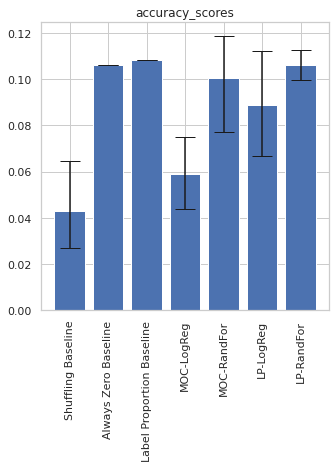

[0.33691787941787943, 0.2601351351351352, 0.23752598752598747, 0.2826819126819127, 0.2445790020790021, 0.25758835758835763, 0.23840436590436587] [(0.3273648648648648, 0.34721933471933475), (0.26013513513513514, 0.26013513513513514), (0.23752598752598753, 0.23752598752598753), (0.27094594594594595, 0.2931652806652807), (0.2348752598752599, 0.25676975051975054), (0.24685550935550937, 0.26897089397089397), (0.23674636174636174, 0.23986486486486486)]


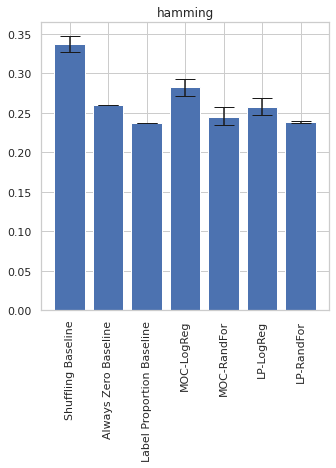

[0.33691787941787943, 0.26010911650011687, 0.16793559419640278, 0.2014183790713124, 0.17504264916839915, 0.18437468742047097, 0.16994620738045743] [(0.3273648648648648, 0.34721933471933475), (0.26010838954510185, 0.2601098390628491), (0.16793394377029544, 0.16793760840779345), (0.19410492527846746, 0.2081585575284779), (0.17012178534303532, 0.18137946985446987), (0.17765803027035593, 0.19162220129388685), (0.16904798596673598, 0.17089954261954263)]


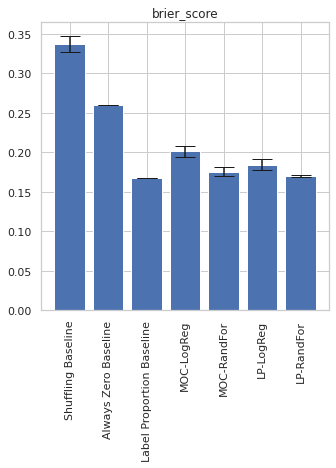

[0.35241758241758236, 1.0, 0.5904365904365906, 0.44112390059592976, 0.5628302852571543, 0.5102015560031643, 0.5848857760978383] [(0.3326173826173826, 0.37077922077922076), (1.0, 1.0), (0.5904365904365905, 0.5904365904365905), (0.41230844627071045, 0.47956646960739724), (0.5220808584180677, 0.6045375639553097), (0.473958227530962, 0.5495560747663552), (0.57862402199705, 0.5914677086911714)]


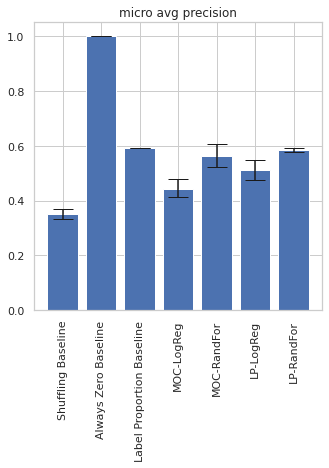

[0.35241758241758236, 0.0, 0.28371628371628377, 0.3201225837565093, 0.2725853603806424, 0.27594033018785635, 0.28782217782217784] [(0.3326173826173826, 0.37077922077922076), (0.0, 0.0), (0.2837162837162837, 0.2837162837162837), (0.2972874874420715, 0.34113459632537935), (0.2539775635382417, 0.28821324911647495), (0.2579290362064989, 0.2955526773685472), (0.28366633366633365, 0.2917082917082917)]


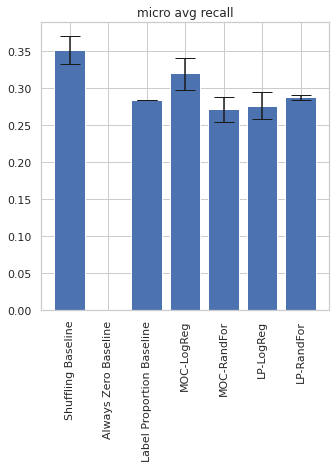

[0.3524175824175824, 0.0, 0.3832658569500675, 0.3708404901193386, 0.36717467935642584, 0.35800997878709123, 0.3857881752628201] [(0.3326173826173826, 0.37077922077922076), (0.0, 0.0), (0.3832658569500675, 0.3832658569500675), (0.34541703965505555, 0.39670985035315165), (0.34579474225839646, 0.38747221232330425), (0.3367476736112805, 0.38313158594673596), (0.38048802029300766, 0.3906354515050167)]


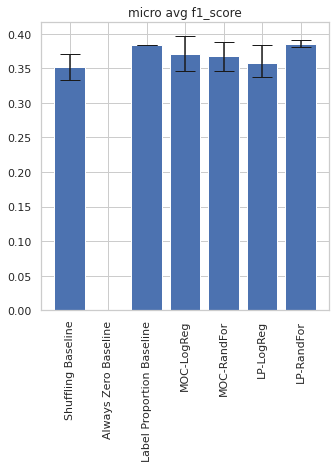

[0.26075748217813927, 0.26905774130512317, 0.27013930912575257, 0.2828410193729325, 0.27316709607200573, 0.2859220213710205, 0.26707742300444937] [(0.2560153367226863, 0.2658852209159644), (0.258119398565672, 0.28362500589157025), (0.25994027021932, 0.28050788093135076), (0.26645401754055364, 0.3006816807017464), (0.2578062476803189, 0.28830002218432893), (0.26753145126335615, 0.30540338571234277), (0.2563155209097884, 0.27772186167302954)]


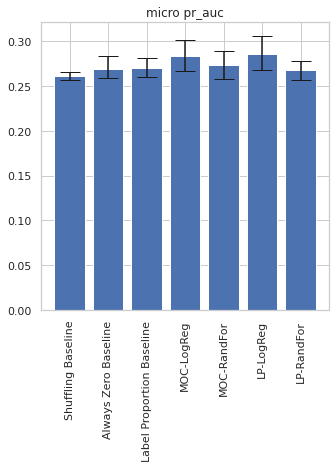

[0.4983587067566326, 0.5006940131763509, 0.5013951765516945, 0.5115650739444932, 0.5060457264309774, 0.511582089797618, 0.49723069328531955] [(0.48507230248380545, 0.5106992216087116), (0.4811939482996932, 0.5249460455532783), (0.48455878041644335, 0.5186617980959685), (0.4930077888881775, 0.5260751587388964), (0.4811449678612725, 0.5267050895509572), (0.4918564946013424, 0.5313216165166869), (0.47658643291306857, 0.515234492295312)]


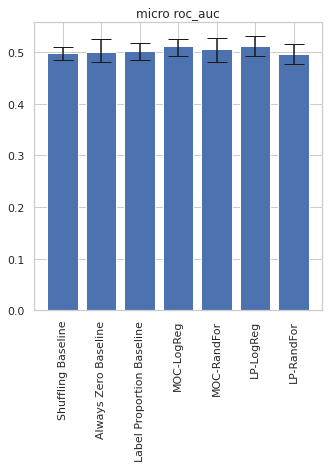

In [45]:
import matplotlib.pyplot as plt

score_names = ['accuracy_scores', 'hamming', 'brier_score', 'micro avg precision', 'micro avg recall', 'micro avg f1_score', 'micro pr_auc', 'micro roc_auc']
for scores, scores_std, score_name in zip([accuracy_scores, hamming, brier_score, precision, recall, f1_score, pr_auc, roc_auc],[accuracy_scores_std, hamming_std, brier_score_std, precision_std, recall_std, f1_score_std, pr_auc_std, roc_auc_std], score_names):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_axes([0,0,1,1])
    print(scores, scores_std)
    scores_std = np.array(list(zip(*scores_std)))
    scores_std[0] = scores - scores_std[0]
    scores_std[1] = scores_std[1] - scores
    ax.bar(model_names, scores, yerr = scores_std, capsize=10)
    plt.xticks(rotation='vertical')
    plt.title(score_name)
    plt.show()

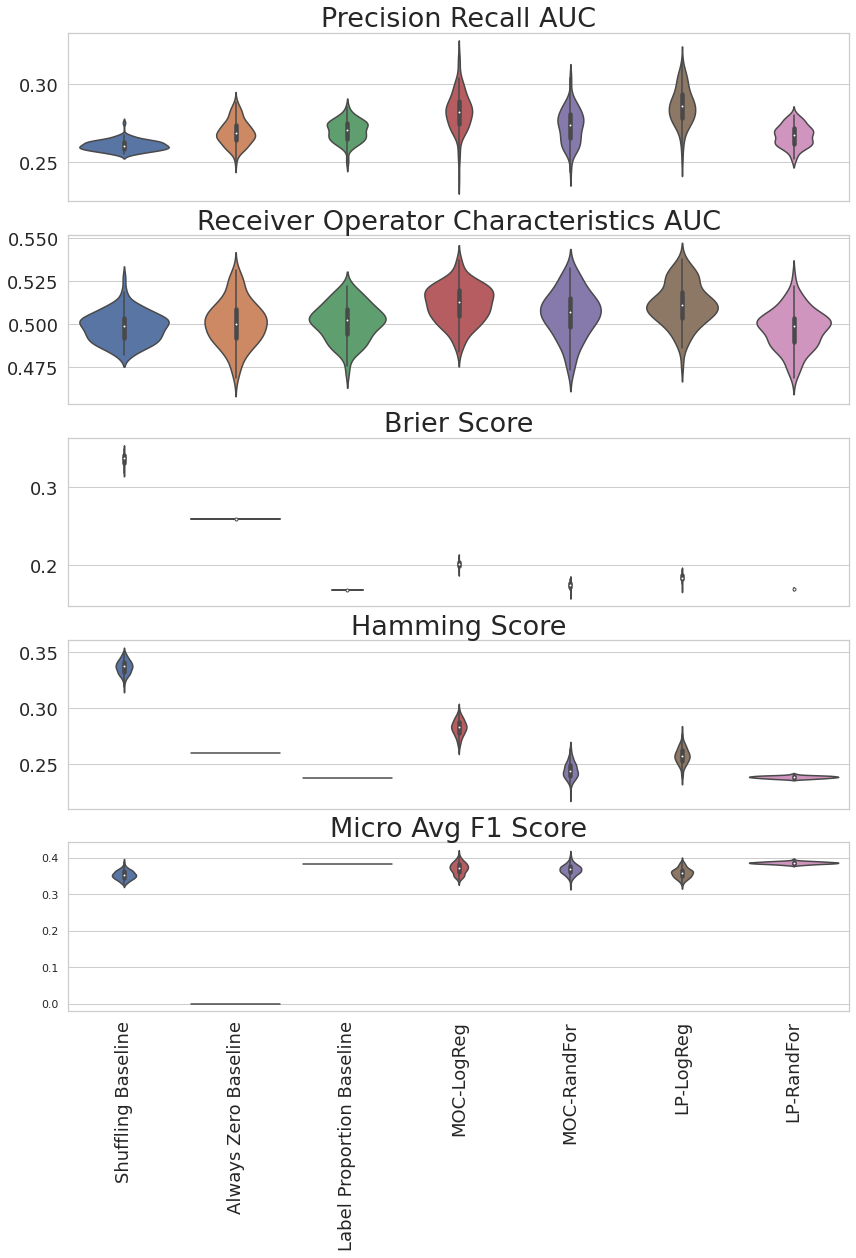

In [46]:
import seaborn as sns
#sns.set(style="whitegrid")

# plot
fig, axes = plt.subplots(5, 1, figsize=(14,18), sharex=True)
fig.suptitle("", fontsize = 25)
sns.violinplot(y=hamming_all, x=model_names_all, ax=axes[3])
axes[3].set_title('Hamming Score',fontsize = 27)
plt.xticks(fontsize=18)
axes[3].tick_params(axis='both', which='major', labelsize=18)


# plot
sns.violinplot(y=brier_score_all, x=model_names_all, ax=axes[2])
axes[2].set_title('Brier Score', fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(3,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[2].tick_params(axis='y', which='major', labelsize=18)


# plot

sns.violinplot(y=pr_auc_all, x=model_names_all, ax=axes[0])
axes[0].set_title("Precision Recall AUC", fontsize =27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16,16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[0].tick_params(axis='y', which='major', labelsize=18)


sns.violinplot(y=roc_auc_all, x=model_names_all, ax=axes[1])
axes[1].set_title("Receiver Operator Characteristics AUC", fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16, 16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[1].tick_params(axis='y', which='major', labelsize=18)


sns.violinplot(y=f1_score_all, x=model_names_all, ax=axes[4])
axes[4].set_title("Micro Avg F1 Score", fontsize = 27)
plt.xticks(rotation=90)
sns.set(rc = {'figure.figsize':(16, 16)})
sns.set(style="whitegrid")
plt.xticks(fontsize=18)
axes[1].tick_params(axis='y', which='major', labelsize=18)


# plt.show()